In [234]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

## Oppgave 1


#### 1 a)

For å representere en polymer av en gitt lengde numerisk er det mulig å lagre hele gitteret, inkludert alle null-elementene, som en matrise, hvor sidelengdene er større enn polymeret. Dette er derimot ikke hensiktsmessig ettersom majoriteten av informasjonen lagret er overflødig. For å forenkle dette kan istedet kun selve posisjonen av hver monomer lagres. Polymeren representeres i et 2D kartesisk kordinatsystem, og dermed kan hver monomer posisjon beskrives av en tuppel med kordinatene x og y. Slik kan hele polymeren være representert av en N x 2 matrise.   

#### 1 b)

In [235]:
def polymer_array(N: int) -> list[int]:
   """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
   return [(i, 0) for i in range(-N//2, N//2)]

#### 1 c)

Energien til en gitt polymer er avhengig av antall monomerer som vekselsvirker med hverandre. Reglene for denne vekselvirkningen er oppgitt i seksjon 2 av prosjektheftet. I algoritme 1 og 2, som begge er Monte Carlo-metoder, velges tilfeldig en monomer som roteres om. Ettersom rotasjon i endemonomerene ikke endrer formen av polymeret, men heller kun roterer hele polymeret, vil det heller ikke oppstå noen endring av energien i polymeret. Dermed er det ikke hensiktsmessig å inkludere endemonomerene i utvalget den tilfeldige monomeren trekkes fra. 

#### 1 d)

In [236]:
def display_polymer(polymer_list: list[int]) -> None:
    """
    Function that displays the polymer on a black background,
    with a color gradient going from white at the beginning to purple at the end of the polymer.
    :param polymer_list: list[int]
    :return: None
    """
    # Determine the maximum absolute values of x and y to ensure a square grid
    max_x = max(abs(x) for _, x in polymer_list)
    max_y = max(abs(y) for y, _ in polymer_list)
    max_extent = max(max_x, max_y)

    # Define square grid size based on the maximum extent
    grid_size = 2 * max_extent + 1

    X, Y = np.meshgrid(range(-max_extent, max_extent + 1), range(-max_extent, max_extent + 1))
    Z = np.zeros(X.shape)  # Background initialized to 0 (black)

    # Map intensity values for the polymer: 0 (background) remains black,
    # Intensity for polymer starts from a small positive value towards 1
    for i, (y, x) in enumerate(polymer_list):
        # Map intensity from a range that starts slightly above 0 to ensure visibility against black
        intensity = (i / (len(polymer_list) - 1)) * 0.99 + 0.01  # Avoids pure black for the first monomer
        adjusted_x = x + max_extent
        adjusted_y = y + max_extent
        Z[adjusted_y, adjusted_x] = intensity

    # Define a colormap: starts with black (for 0 intensity), transitions from white to purple
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "white", "purple"])

    plt.figure(figsize=(6,6))  # Adjust figure size as needed
    plt.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')  # 'auto' shading for smooth transition
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')  # Optional: Hide axes for a cleaner visualization
    plt.show()

#legger den med nå siden den gjør oppgave 1g) lettere å visualisere

def display_polymer_side_by_side(polymer_list1: list[int], polymer_list2: list[int], name1: [str], name2: [str]) -> None:
    """
    Rewrote the display_polymer function to display two polymers side by side to increase readability.

    In order to simpliefy the automatic grid sizing a subfunction for this purpose is an easy solution
    """
    def plot_polymer(ax, polymer_list):
        max_x = max(abs(x) for _, x in polymer_list)
        max_y = max(abs(y) for y, _ in polymer_list)
        max_extent = max(max_x, max_y)

        grid_size = 2 * max_extent + 1

        X, Y = np.meshgrid(range(-max_extent, max_extent + 1), range(-max_extent, max_extent + 1))
        Z = np.zeros(X.shape)

        for i, (y, x) in enumerate(polymer_list):
            intensity = (i / (len(polymer_list) - 1)) * 0.99 + 0.01
            adjusted_x = x + max_extent
            adjusted_y = y + max_extent
            Z[adjusted_y, adjusted_x] = intensity

        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "white", "purple"])

        ax.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')
        ax.set_aspect('equal', adjustable='box')
        ax.axis('off')

    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the first polymer on the left subplot
    plot_polymer(axes[0], polymer_list1)
    axes[0].set_title(name1)

    # Display the second polymer on the right subplot
    plot_polymer(axes[1], polymer_list2)
    axes[1].set_title(name2)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

    


#### 1 e)

We added our own criteria, we make it a requirement that no monomer can share coordinates with another, thus it cannot be on top of itself

In [237]:

def is_intact_polymer_array(polymer_object: list[int], N: int) -> bool:
    """
    Function that checks if the polymer is intact
    :param polymer_object: list[int]
    :param N: int
    :return: bool
    """

    # convert from numpy array to list
    polymer_object = list(polymer_object)

    # Check if the polymer is the right length
    if len(polymer_object) != N:
        return False

    # Go through each monomer and check if it has a neighbor
    for i in range(N):
        # Hvis det ikke er den første monomeren, sjekk forrige nabo
        if i > 0 and not (abs(polymer_object[i][0] - polymer_object[i-1][0]) == 1 and polymer_object[i][1] == polymer_object[i-1][1]) and not (polymer_object[i][0] == polymer_object[i-1][0] and abs(polymer_object[i][1] - polymer_object[i-1][1]) == 1):
            return False
        
        # If it is not the last monomer, check next neighbor
        if i < N - 1 and not (abs(polymer_object[i][0] - polymer_object[i+1][0]) == 1 and polymer_object[i][1] == polymer_object[i+1][1]) and not (polymer_object[i][0] == polymer_object[i+1][0] and abs(polymer_object[i][1] - polymer_object[i+1][1]) == 1):
            return False
        
        # Check if the monomer is on top of another monomer\n",
        if polymer_object.count(polymer_object[i]) > 1:
            return False
    return True

#### 1f)

In [238]:
def rotate_polymer_array(polymer_object: list[int], xy_val: tuple[int, int], counter_clockwise: bool) -> list[int]:
    """
    Function that rotates the smaller half of the polymer around a point with 90 degrees
    :param polymer_object: list[int]
    :param xy_val: tuple[int, int]
    :param counter_clockwise: bool
    :return: list[int]
    """
    rotated_polymer = []
    rotation_index = polymer_object.index(xy_val)

    # Determine which half to rotate (smaller half or front half if in the middle)
    if rotation_index <= len(polymer_object) // 2:
        # Rotate the front half
        polymer_to_rotate = polymer_object[:rotation_index + 1]
        polymer_remaining = polymer_object[rotation_index + 1:]
    else:
        # Rotate the back half
        polymer_to_rotate = polymer_object[rotation_index:]
        polymer_remaining = polymer_object[:rotation_index]

    # Apply rotation to the chosen half
    for x, y in polymer_to_rotate:
        dx, dy = x - xy_val[0], y - xy_val[1]
        if counter_clockwise:
            new_x, new_y = xy_val[0] - dy, xy_val[1] + dx
        else:
            new_x, new_y = xy_val[0] + dy, xy_val[1] - dx
        rotated_polymer.append((new_x, new_y))

    # Combine the rotated half with the unrotated half
    if rotation_index <= len(polymer_object) // 2:
        rotated_polymer.extend(polymer_remaining)
    else:
        rotated_polymer = polymer_remaining + rotated_polymer

    return rotated_polymer

#### 1g)

In [239]:

def algorithm1_array(N: int, Ns: int) -> (list[int], int):
    counter = 0
    polymer_object = polymer_array(N)

    for _ in range(Ns):
        # Choose a random monomer
        random_monomer_index = np.random.randint(0, N)
        random_monomer = polymer_object[random_monomer_index]

        # Randomly choose rotation direction
        rotate_clockwise = np.random.choice([True, False])

        # Rotate the polymer
        rotated_polymer = rotate_polymer_array(polymer_object, random_monomer, not rotate_clockwise)

        # Check if the rotated polymer is intact
        if is_intact_polymer_array(rotated_polymer, N):
            counter += 1
            polymer_object = rotated_polymer

    return polymer_object, counter

In [240]:
polymer_4, _ = algorithm1_array(15, 4)
polymer_1000, _ = algorithm1_array(15, 1000)
np.savez("polymer.npz", polymer1 = polymer_4, polymer2 = polymer_1000)

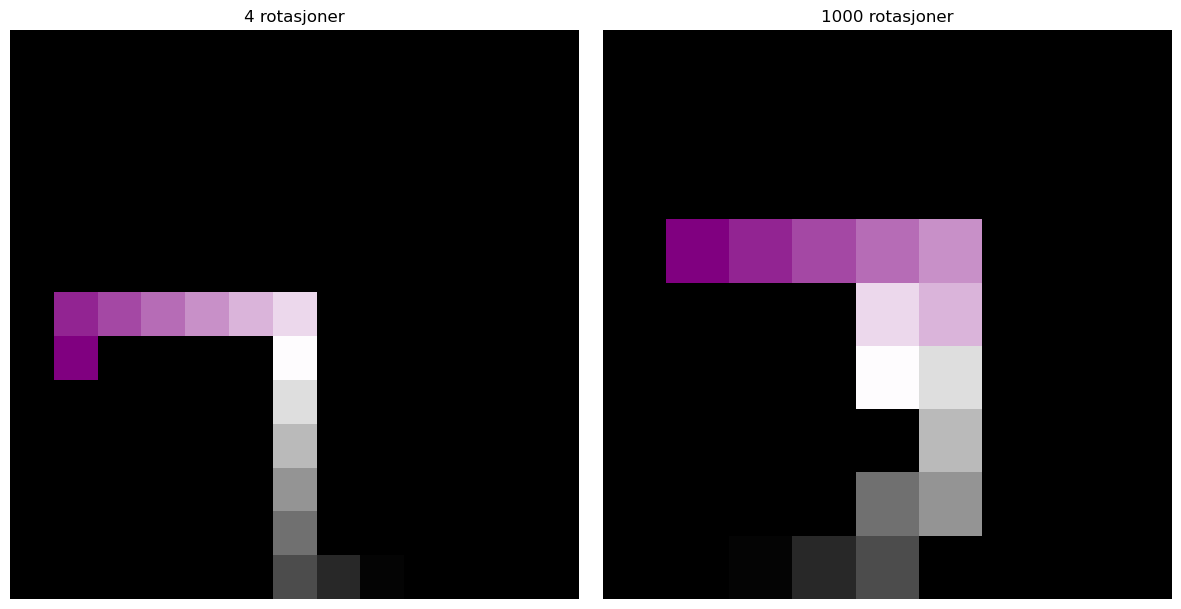

In [241]:
polymerene = np.load("polymer.npz")
polymer_4_load = polymerene["polymer1"]
polymer_1000_load = polymerene["polymer2"]

display_polymer_side_by_side(polymer_4_load, polymer_1000_load, "4 rotasjoner", "1000 rotasjoner")

#### 1h)

For å optimalisere tok vi i bruk numpy arrays for å forsøke å øke hastigheten. Funksjonene fra tidligere oppgaver måtte også endres for å være tilbøyelig for numpy arrays.

In [242]:
# implementasjon med numpy array
def create_polymer(N: int) -> np.ndarray:
    """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
    return np.array([(i, 0) for i in range(-N//2, N//2)])

def is_intact_polymer_np(polymer_object: np.ndarray, N: int) -> bool:
    """
    Function that checks if the polymer is intact for a NumPy array implementation.
    :param polymer_object: NumPy array of shape (N, 2), representing N monomers' coordinates.
    :param N: int, the expected length of the polymer.
    :return: bool, True if the polymer is intact, False otherwise.
    """
    # Check if the polymer is the right length
    if polymer_object.shape[0] != N:
        return False

    # Ensure all monomer positions are unique
    if np.unique(polymer_object, axis=0).shape[0] != N:
        return False

    # Calculate the differences between consecutive monomers
    diffs = np.diff(polymer_object, axis=0)
    
    # Check for horizontal or vertical adjacency between consecutive monomers
    valid_horizontal = (np.abs(diffs[:, 0]) == 1) & (diffs[:, 1] == 0)
    valid_vertical = (np.abs(diffs[:, 1]) == 1) & (diffs[:, 0] == 0)
    
    if not np.all(valid_horizontal | valid_vertical):
        return False

    return True

def rotate_polymer_np(polymer: np.ndarray, center: tuple[int, int], counter_clockwise: bool = True) -> np.ndarray:
    """
    Optimized function to rotate the shortest end of the polymer 90 degrees around a specified monomer (center) using NumPy.
    If the center is in the middle, the front half is rotated.
    
    :param polymer: NumPy array of shape (N, 2), representing N monomers.
    :param center: Center point for rotation, as a tuple of (x, y), must be a monomer in the polymer.
    :param counter_clockwise: True for counter-clockwise rotation, False for clockwise.
    :return: NumPy array representing the rotated polymer.
    """
    # Find the index of the center monomer
    center_index = np.where((polymer == center).all(axis=1))[0][0]
    
    # Determine the rotation matrix
    rotation_matrix = np.array([[0, -1], [1, 0]]) if not counter_clockwise else np.array([[0, 1], [-1, 0]])

    # Determine which half to rotate
    if center_index <= len(polymer) // 2:
        # Rotate the first half
        segment_to_rotate = polymer[:center_index + 1]
        remaining_segment = polymer[center_index + 1:]
        translated_segment = segment_to_rotate - center
        rotated_translated_segment = np.dot(translated_segment, rotation_matrix) + center
        return np.vstack((rotated_translated_segment, remaining_segment))
    else:
        # Rotate the second half
        segment_to_rotate = polymer[center_index:]
        remaining_segment = polymer[:center_index]
        translated_segment = segment_to_rotate - center
        rotated_translated_segment = np.dot(translated_segment, rotation_matrix) + center
        return np.vstack((remaining_segment, rotated_translated_segment))
    
def algorithm1_optimized(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """
    Numpy optimized algorithm to generate a polymer of length N and rotate it Ns times.
    :param N: int, the length of the polymer.
    :param Ns: int, the number of steps to take.
    :return: tuple, (polymer, number of steps taken).
    """
    counter = 0
    polymer_obj = create_polymer(N)

    for _ in range(Ns):
        random_index = np.random.randint(0, N)
        random_monomer = polymer_obj[random_index]
        counter_clockwise = np.random.choice([True, False])
        rotated_polymer = rotate_polymer_np(polymer_obj, random_monomer, counter_clockwise)
        
        if is_intact_polymer_np(rotated_polymer, N):
            counter += 1
            polymer_obj = rotated_polymer
        else:
            pass
    return polymer_obj, counter

In [243]:
# check for optimization

# time the algorithm using timeit

%timeit algorithm1_array(100, 1000)
%timeit algorithm1_optimized(100, 1000)

152 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
80.7 ms ± 9.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Her ser vi at å bruke Numpy arrays og optimalisere rundt linæralgebra for rotasjon gir en betydelig ytelseøkning ovenfor Python array.

#### 1i)

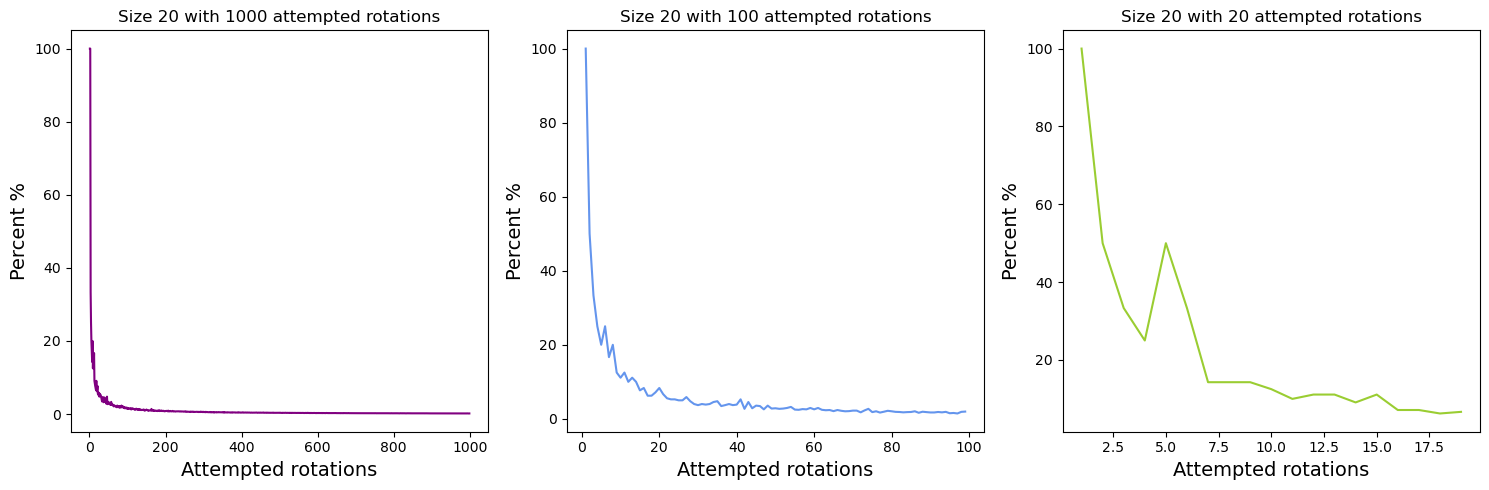

In [244]:
def plot_prosent(N: int, N_s: int) -> list[float]:
    """
    plots the percentage of rotations based on attempted rotations
    """
    x_arr = []
    y_arr = []
    for i in range(1, N_s):
        _, count = algorithm1_optimized(N, i)
        x_arr.append(i)
        y_arr.append(100/count)
    return x_arr, y_arr
N = 20
N_s = 1000
x_arr, y_arr = plot_prosent(N,N_s)
fig, axs =plt.subplots(1,3, figsize = (15,5))
axs[0].plot(x_arr,y_arr, color = "purple")
axs[0].set_title(f"Size {N} with {N_s} attempted rotations")
axs[0].set_ylabel("Percent %", fontsize = 14)
axs[0].set_xlabel("Attempted rotations", fontsize = 14)


N_s = 100
x_arr, y_arr = plot_prosent(N,N_s)
axs[1].plot(x_arr,y_arr, color = "cornflowerblue")
axs[1].set_title(f"Size {N} with {N_s} attempted rotations")
axs[1].set_ylabel("Percent %", fontsize = 14)
axs[1].set_xlabel("Attempted rotations", fontsize = 14)

N_s = 20
x_arr, y_arr = plot_prosent(N,N_s)
axs[2].plot(x_arr,y_arr, color = "yellowgreen")
axs[2].set_title(f"Size {N} with {N_s} attempted rotations")
axs[2].set_ylabel("Percent %", fontsize = 14)
axs[2].set_xlabel("Attempted rotations", fontsize = 14)
plt.tight_layout()
plt.show()




### 1j)

In [245]:

def create_V_matrix(N: int, value: float) -> list[int]:
    """
    Function creates N x N matrix with 0 across, over and under the diagonal
    :param N: int
    """
    # Create an N x N matrix with 0
    matrix = np.zeros((N, N), dtype=int) 

    #sets upper triangle in V matrix to -1
    matrix[np.triu_indices(N, k=2)] = value  

    #sets lower triangle in V matrix to -1
    matrix[np.tril_indices(N, k=-2)] = value  

    return matrix



In [246]:
def calculate_polymer_energy(polymer, V):
    """
    Beregner energien til en polymer basert på en liste av monomerposisjoner og en vekselvirkningsmatrise V.

    :param polymer: List av tuples som representerer posisjonene til monomerene i polymeren.
    :param V: Numpy matrise som representerer styrken av vekselvirkningene mellom monomerene.
    :return: Energien til polymeren.
    """
    N = len(polymer)  # Antall monomerer i polymeren
    E = 0  # Initialiserer energien

    # Gå gjennom alle par av monomerer for å beregne energibidraget
    for m in range(N):
        for n in range(N):
            if n != m and n != m+1 and n != m-1:  # Sjekker at n er en gyldig nabo
                if is_nearest_neighbor(polymer[m], polymer[n]):
                    E += V[m, n]

    # Normaliser energien siden alle vekselvirkninger telles to ganger
    E = E / 2
    return E

def is_nearest_neighbor(monomer1, monomer2):
    """
    Sjekker om to monomerer er nærmeste naboer i et kvadratisk gitter.

    :param monomer1: Tuple som representerer posisjonen til det første monomeret.
    :param monomer2: Tuple som representerer posisjonen til det andre monomeret.
    :return: True hvis de er nærmeste naboer, ellers False.
    """
    # Beregner avstanden mellom monomerene
    dx = abs(monomer1[0] - monomer2[0])
    dy = abs(monomer1[1] - monomer2[1])

    # Sjekker om avstanden tilsvarer nærmeste naboer
    return (dx == 1 and dy == 0) or (dx == 0 and dy == 1)

In [247]:
# testing energy
polymerene = np.load("polymer.npz")
polymer_4_load = polymerene["polymer1"]
polymer_1000_load = polymerene["polymer2"]

V = create_V_matrix(15, -1)
print(f'Energien til polymeret med 4 forsøkte rotasjoner er: {calculate_polymer_energy(polymer_4_load, V)}')

print(f'Energien til polymeret med 1000 forsøkte rotasjoner er: {calculate_polymer_energy(polymer_1000_load, V)}')

Energien til polymeret med 4 forsøkte rotasjoner er: 0.0
Energien til polymeret med 1000 forsøkte rotasjoner er: -2.0


## Oppgave 2: Monte Carlo-simuleringer

#### 2 a)

In [248]:
def algorithm2(polymer_array: np.ndarray, Ns: int, interaction_matrix: np.ndarray, temperature: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs a Monte Carlo simulation using the Metropolis algorithm for a polymer.
    
    :param polymer_array: Initial position of the polymer as a NumPy array of shape (N, 2).
    :param Ns: Number of valid rotation attempts.
    :param interaction_matrix: Numpy matrix representing interaction strengths between monomers.
    :param temperature: Dimensionless temperature of the system.
    :return: Tuple consisting of the updated polymer array and energy array.
    """
    N = polymer_array.shape[0]
    energy_array = np.zeros(Ns)
    current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
    boltzmann_constant = 1.38e-23  # Boltzmann constant in J/K
    beta = 1 / (temperature * boltzmann_constant)  # Inverse temperature, assuming kB = 1 for simplicity
    i = 0

    while i < Ns:
        random_monomer_index = np.random.randint(N)
        rotate_clockwise = np.random.choice([True, False])
        rotated_polymer_array = rotate_polymer_np(polymer_array, polymer_array[random_monomer_index], not rotate_clockwise)

        if is_intact_polymer_np(rotated_polymer_array, N):
            current_energy = calculate_polymer_energy(polymer_array, interaction_matrix)
            new_energy = calculate_polymer_energy(rotated_polymer_array, interaction_matrix)
            delta_energy = new_energy - current_energy
            if delta_energy < 0: 
                polymer_array = rotated_polymer_array
                current_energy = new_energy
            if np.random.rand() < np.exp(-beta * delta_energy*4.0e-21):
                polymer_array = rotated_polymer_array
                current_energy = new_energy
                #print("random event, ")
            energy_array[i] = current_energy
            i += 1  # Increment i after each valid rotation attempt
                

    return polymer_array, energy_array

#### 2b)

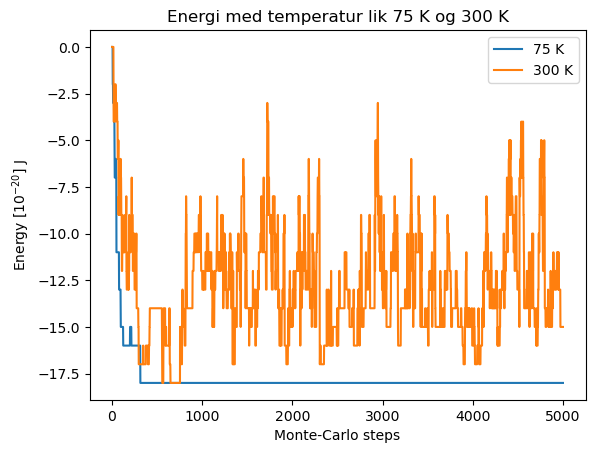

In [249]:
N_s = 5000
polymer_30 = create_polymer(30)
V_matrix = create_V_matrix(30, -1)
polymer_array_k, energy_array_k  = algorithm2(polymer_30, N_s, V_matrix, 75)
polymer_array_v, energy_array_v = algorithm2(polymer_30, N_s, V_matrix,300)

plt.plot(np.linspace(0,N_s,N_s),energy_array_k, label = "75 K")
plt.plot(np.linspace(0,N_s,N_s),energy_array_v, label = "300 K")
plt.title("Energi med temperatur lik 75 K og 300 K")
plt.xlabel("Monte-Carlo steps")
plt.ylabel(r'Energy [$10^{-20}$] J')
plt.legend()
plt.show()

I grafen ovenfor vises utviklingen av energinivået til i polymerer etterhvert som de blir utsatt for flere tilfeldige rotasjoner simulert av algoritme2. Energien til polymeret er plottet langs y-aksen og antall monte-carlo steg gjort av algoritme2 langs x-aksen. De to polymerene illustrert i plottet er like lange, og har ellers nesten de samme parameterene, som antall tilfeldige rotasjoner, 5000, og lik v-matrise. De skilles derimot i hvilken temperatur de har. Den blå grafen har en temperatur på 75K og den og den oransje er 300K. Videre omtales de henholdsvis som kald og varm polymer.

Fra plottet kan det observeres at energinivået til den varme polymeren er mye mindere stabilt enn det kalde polymeret, og varier gjennom hele simuleringen. Det er tydelig at snitt energien til den kalde polymeren er lavere enn den varmepolymeren. Likevell er det mulig at den varme polymeren har til tider lavere energi enn den kalde, før energien endrers med en ny rotasjon. Dette er et resultat av at den varme polymeren har høyere grunnenergi og er dermed mer volatil. Polymerene veskelsvirker med seg selv etterhvert som de brettes, og dette minker sannsynligheten for at en ny rotasjon vil føre til en lavere energinivå for polymeret. Dette betegnes for et lokalt energiminima og polymeren vil kun flytte seg ut av dette ved tilfeldige rotasjoner bestemt kun av sannsynlighet. I den blå grafen kan dette sees som små hopp i energinivået før det kalde polymeret, som oftest, brettes tilbake inn i det lokale energiminimaet. Den varme polymeren derimot har mer energi og har dermed mye høyere sannsynlighet for å hoppe helt ut av lokale energiminima og rotere inn i et nytt minima. Dette vises i grafen som den kaotiske bevegelsen av energinivået til den varme polymeren.

### 2c)

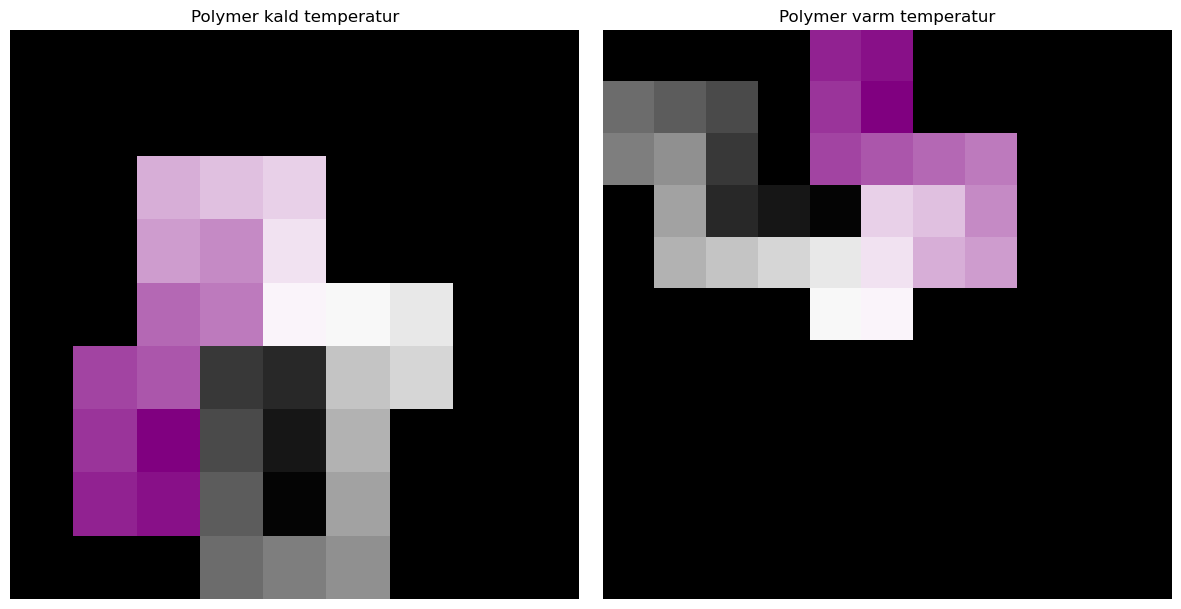

In [250]:
#Funksjonen display_polymer_side_by_side er definert i oppgave 1d)

display_polymer_side_by_side(polymer_array_k, polymer_array_v, "Polymer kald temperatur", "Polymer varm temperatur")

Illustrasjonene over viser sluttposisjonen til den kalde polymeren til venstre og den varme polymeren til høyre. Som diskutert i forrige oppgave vil den varme polymeren som regel, ikke alltid,  ha høyere sluttenergi enn den kalde polymeren. Ettersom energien avhenger av vekselsvirkning mellom monomerer vil dette tilsi at den varme polymeren har som oftest større utstrekning enn den kalde.

### 2d)

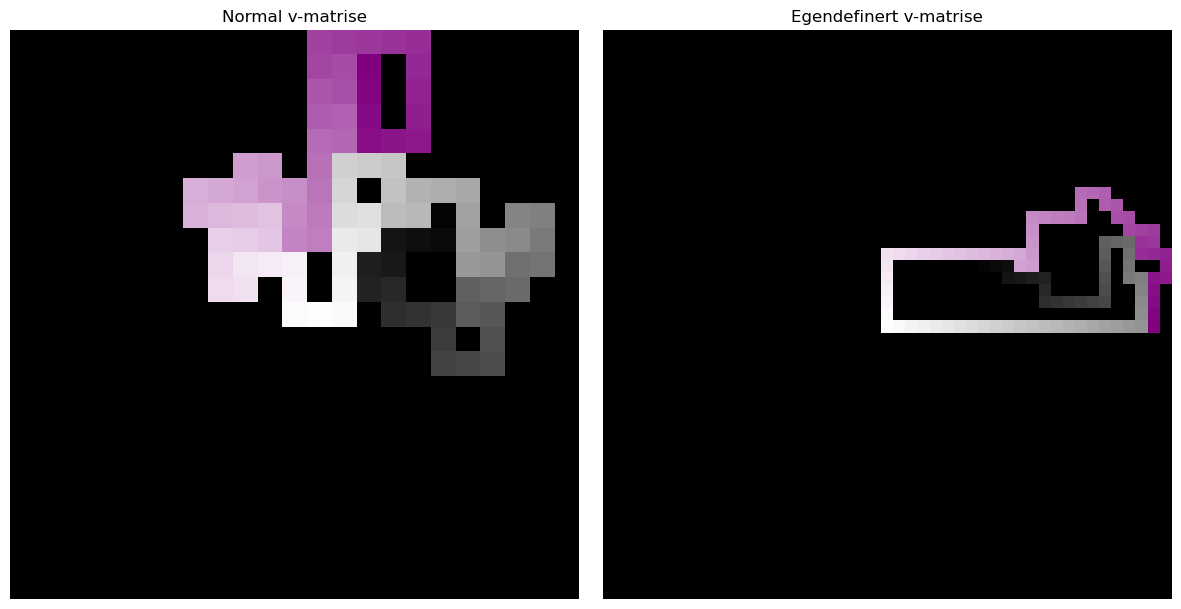

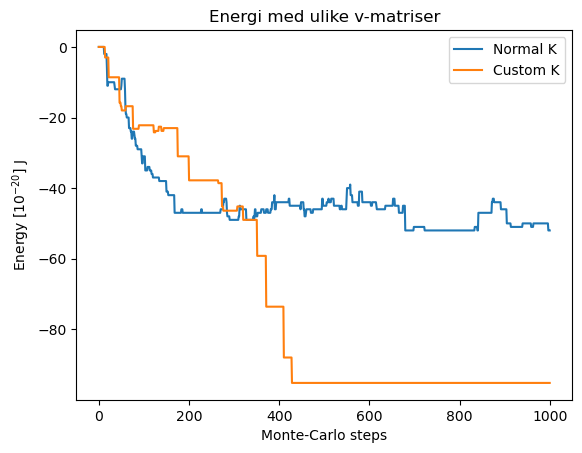

In [251]:
def create_custom_v_matrix(n: [int], value: [float]) -> list[int]:
    """
    Function to create a custom symmetrical V matrix where the elements inside the
    matrix increase by one for every step away rom the axis.
    """
    # Create an empty matrix
    matrix = np.zeros((n, n), dtype=int)

    # Create indices for the upper triangle
    rows, cols = np.triu_indices(n, k=6)

    # Fill the upper triangle with values increasing by one for each number away from the main diagonal
    matrix[rows, cols] = matrix[cols, rows] = np.abs(rows - cols) + 1

    return matrix*-value 

def create_X_matrix(size: int, value=-1.0) -> np.ndarray:
    """
    Function to create a symmetrical matrix with a "X" pattern of zeros and -1 elsewhere.
    param size: int, the size of the matrix.
    param value: float, the value to use for the "X" pattern.
    """
    matrix = -np.ones((size, size)) * value  # Initialize with -value
    
    # Fill in the matrix to form an "X" pattern with zeros, -1 elsewhere
    for i in range(size):
        for j in range(size):
            if i == j or i + j == size - 1:  # Conditions for the "X" pattern
                matrix[i, j] = matrix[j, i] = 0  # Part of the "X" and diagonal
    
    return matrix


#Comparison of polymer using standard V-matrix vs the custom matrix
N_s = 1000

normal_polymer, normal_energy_array = algorithm2(create_polymer(100), N_s, create_V_matrix(100, -1), 300)
custom_polymer, custom_energy_array = algorithm2(create_polymer(100), N_s, create_custom_v_matrix(100, 0.05), 300)

display_polymer_side_by_side(normal_polymer, custom_polymer, "Normal v-matrise", "Egendefinert v-matrise")

plt.plot(np.linspace(0,N_s,N_s),normal_energy_array, label = "Normal V-matrix")
plt.plot(np.linspace(0,N_s,N_s),custom_energy_array, label = "Custom V-matrix")
plt.title("Energi med ulike v-matriser")
plt.xlabel("Monte-Carlo steps")
plt.ylabel(r'Energy [$10^{-20}$] J')
plt.legend()
plt.show()

Drøftedel av oppgave 2d)

#### 2e)

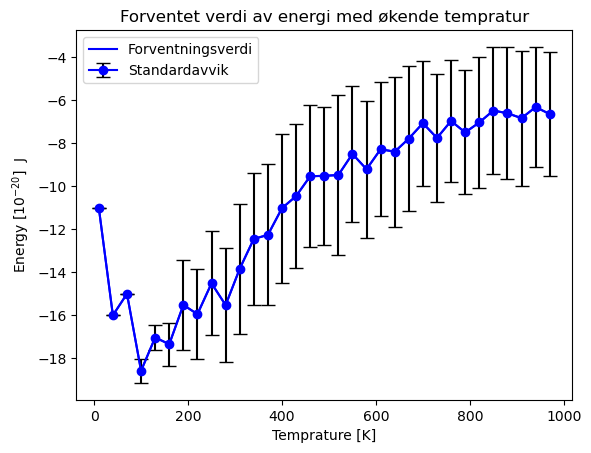

In [263]:
def excpected_energy(N: int, N_s: int, V_matrix: list[int]) -> (list[float], list[float], list[float]):
    """
    Function that calculates expected energy, and its standard deviation
    param N: length of polymer
    param N_s: attempted rotations
    param V_matrix: matrix with values of energy
    """
    temprature = np.arange(10,1000, 30) #creates array with temprature
    polymer1 = create_polymer(N) #creates polymer with length N
    expected = []
    deviation = []
    for i in temprature:
        _, energy_array = algorithm2(polymer1, N_s, V_matrix,i) 
        energy_array = energy_array[1000:] #exlude first 1000 simulations
        expected.append(np.mean(energy_array))
        deviation.append(np.std(energy_array))
    return expected, deviation, temprature
N = 30
N_s = 5000
expected, deviation, temprature = excpected_energy(N, N_s, create_V_matrix(N,-1))
plt.plot(temprature,expected, label= "Forventningsverdi", color = "b")
plt.errorbar(temprature,expected ,  yerr= (deviation), fmt='-o', color = "b", ecolor = "black",capsize=5, label='Standardavvik')
plt.title("Forventet verdi av energi med økende tempratur")
plt.xlabel("Temprature [K]")
plt.ylabel(r'Energy [$10^{-20}$]  J')
plt.legend()
plt.show()

#### 2f)

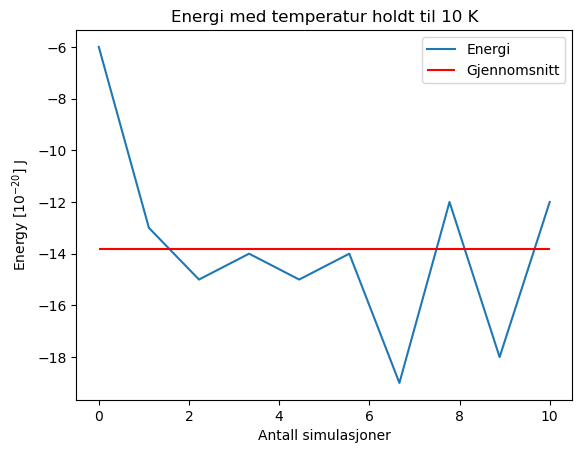

In [267]:
N_s = 5000

def constant_temprature_sim(N, N_s, V_matrix, temprature):
    polymer1 = create_polymer(N)
    expected = []
    for i in range(10):
        _, energy = algorithm2(polymer1,N_s, V_matrix, temprature)
        energy = energy[1000:]
        expected.append(np.mean(energy))
    return expected
energies_at_10 = constant_temprature_sim(N, N_s, create_V_matrix(N, -1), 10)
plt.plot(np.linspace(0,10,10),energies_at_10, label = "Energi")
plt.hlines(np.mean(energies_at_10),0,10, color = "r", label = "Gjennomsnitt")
plt.title("Energi med temperatur holdt til 10 K")
plt.xlabel("Antall simulasjoner")
plt.ylabel(r'Energy [$10^{-20}$] J')
plt.legend()
plt.show()

### 2g)

In [254]:
def create_random_v_matrix(n: [int], lowerbound: [float], upperbound: [float]) -> list[int]:
    """
    Function to create a symmetrical v-matrix where the elements in the matrix are randomized between
    an upper- and lower-bound.
    """
    # Create an empty matrix
    matrix = np.zeros((n, n), dtype=float)

    # Create indices for the upper triangle
    rows, cols = np.triu_indices(n, k=2)

    #Randomizing the elements within the triangle within the specified bounds
    random_values = np.random.uniform(lowerbound, upperbound, len(rows))
    matrix[rows, cols] = matrix[cols, rows] = random_values

    return matrix*-1

def max_distance(polymer1):
    """ 
    Function that finds the maximun distance between two monomers in a polymer using numpy liner algebra
    """
    #Calculating the pairwise distances between all monomers
    pairwise_distances = np.linalg.norm(polymer1 - polymer1[:, np.newaxis], axis=-1)

    #Excluding the diagonal (distance between a monomer and itself)
    np.fill_diagonal(pairwise_distances, 0)

    #Finding the maximum distance
    maximum_distance = np.max(pairwise_distances)

    return maximum_distance
    
def excpected_energy_and_size(N: int, N_s: int, V_matrix: list[int]) -> (list[float], list[float], list[float], list[float]):
    """
    Function that calculates expected energy, and its standard deviation, as well as its size (diameter).
    param N: length of polymer
    param N_s: attempted rotations
    param V_matrix: matrix with values of energy
    """

    temprature = np.arange(10,1000, 30) #creates array with temprature
    polymer1 = create_polymer(N) #creates polymer with length N
    excpected_energy = []
    excpected_size = []
    deviation = []


    #For-loop that iterates through each randomized polymer for each temperature
    for i in temprature:
        polymer_array, energy_array = algorithm2(polymer1, N_s, V_matrix,i) 
        energy_array=energy_array[1000:] #exlude first 1000 simulations
        excpected_energy.append(np.mean(energy_array))
        deviation.append(np.std(energy_array))
        excpected_size.append(max_distance(polymer_array))

    return excpected_energy, deviation, temprature, excpected_size



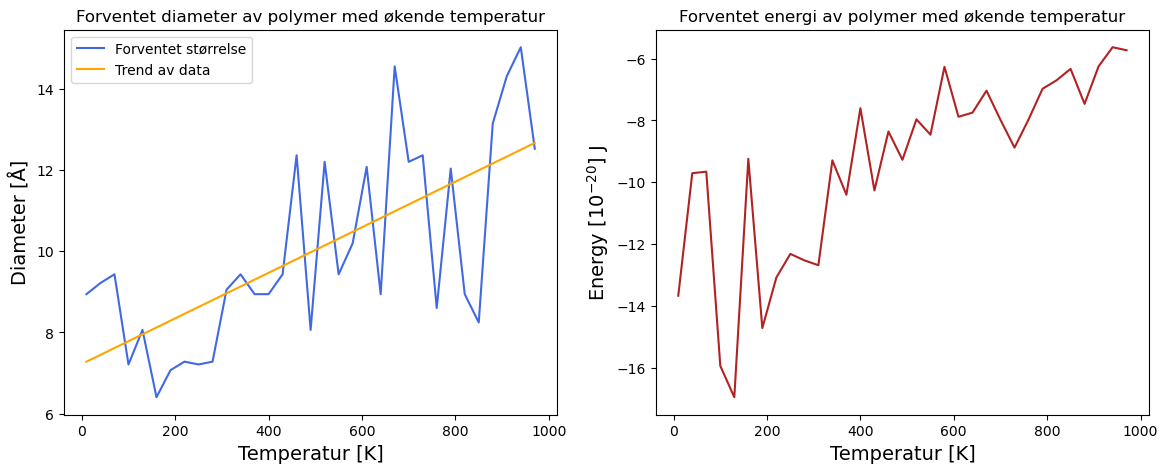

In [275]:
N = 30
N_s = 5000
expected, deviation, temprature, size = excpected_energy_and_size(N, N_s, create_X_matrix(N,1))

x = temprature
y = size
coefficients = np.polyfit(x, y, deg=1)
slope, intercept = coefficients
y_pred = np.polyval(coefficients, x)
fig, axs = plt.subplots(1,2, figsize = (14,5))
axs[0].plot(temprature, size, label= "Forventet størrelse", color = "royalblue")
axs[0].set_title("Forventet diameter av polymer med økende temperatur")
axs[0].set_xlabel("Temperatur [K]", fontsize = 14)
axs[0].set_ylabel("Diameter [Å]", fontsize = 14)
axs[0].plot(temprature, y_pred, label= "Trend av data", color = "orange")
axs[0].legend()

axs[1].plot(temprature, expected, color = "firebrick")
axs[1].set_title("Forventet energi av polymer med økende temperatur")
axs[1].set_xlabel("Temperatur [K]", fontsize = 14)
axs[1].set_ylabel(r'Energy [$10^{-20}$] J', fontsize = 14)

plt.show()

### 2h)

In [256]:
# Values to be used in 2h, using x matrix
N = 30
N_s = 5000
#expected, deviation, temprature, size = excpected_energy_and_size(N, N_s, create_X_matrix(N,1))

In [257]:
def expected_energy_and_size_decreasing(N: int, N_s: int, V_matrix: list[int]) -> (list[float], list[float], list[float], list[float]):
    """
    Function that calculates expected energy, and its standard deviation, as well as its size (diameter).
    param N: length of polymer
    param N_s: attempted rotations
    param V_matrix: matrix with values of energy
    """

    temperature = np.arange(10, 1000, 30)  # Creates array with temperature
    polymer1 = create_polymer(N)  # Presumably creates a polymer with length N
    expected_energy = []
    expected_size = []
    deviation = []

    # Reverse the temperature array to start from the highest temperature
    temperature_reversed = temperature[::-1]

    # For-loop that iterates through each randomized polymer for each temperature, starting from the highest
    for i in range(len(temperature_reversed)):
        polymer_array, energy_array = algorithm2(polymer1, N_s, V_matrix, temperature_reversed[i])
        energy_array = energy_array[1000:]  # Exclude first 1000 simulations
        expected_energy.append(np.mean(energy_array))
        deviation.append(np.std(energy_array))
        expected_size.append(max_distance(polymer_array))
        polymer1 = polymer_array

    print(f"length of expected_energy: {len(expected_energy)}")
    return expected_energy, deviation, temperature_reversed, expected_size

length of expected_energy: 33


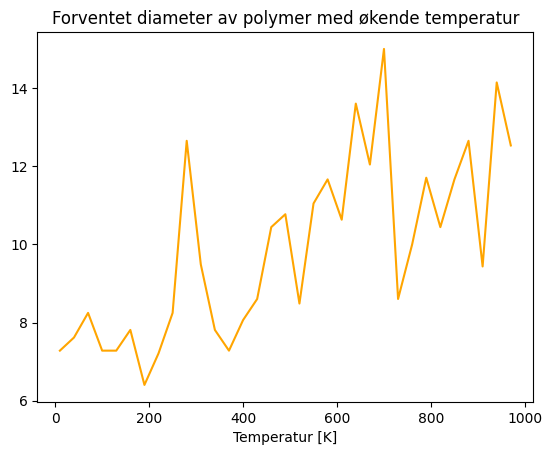

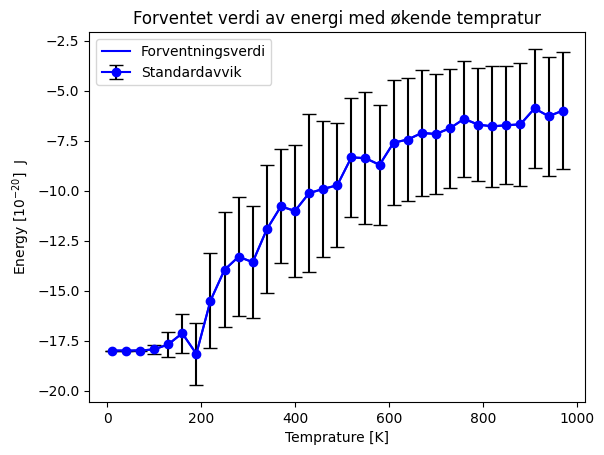

In [112]:
#Test
N = 30
N_s = 5000
expected_energy, deviation, temperature_reversed, size = expected_energy_and_size_decreasing(N, N_s, create_X_matrix(N,1))

plt.plot(temperature_reversed, size, label= "Forventet størrelse", color = "orange")
#plt.plot(temperature_reversed, y_pred, label= "Lin. reg.", color = "blue")
#plt.hlines(np.mean(energies_at_10),0,10, color = "r", label = "Gjennomsnitt")
plt.title("Forventet diameter av polymer med økende temperatur")
plt.xlabel("Temperatur [K]")
#plt.ylabel(r'Size') har ikke regnet ut den faktiske størrelsen ennå
plt.show()

plt.plot(temperature_reversed,expected_energy, label= "Forventningsverdi", color = "b")
plt.errorbar(temperature_reversed,expected_energy, yerr= (deviation), fmt='-o', color = "b", ecolor = "black",capsize=5, label='Standardavvik')
plt.title("Forventet verdi av energi med økende tempratur")
plt.xlabel("Temprature [K]")
plt.ylabel(r'Energy [$10^{-20}$]  J')
plt.legend()
plt.show()